In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cell-images-for-detecting-malaria:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F87153%2F200743%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240614%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240614T060153Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db7cb519c0d7e3a467d351e72db6b75ebc3dcdd9c7b663307fb9c14f7b4013cb466c096d74c1051111dbebbc07d424b54a08ea0d51b8a3bad8a270171b8f29db5afebab427e591246dfb139598eac462945a52504ea383993dfd54495a1ceaa51b0493e03a9ee762f4787c528a6769c1d630dd5639af345114d752a6ca191ea93eb3171adf2614530b1fd230ccbced313f9f7bc8a6172d9c6297b65ba927f8057d8beaaa8848306bd3def93ec2e4bad6bc2d17455769b2fc25b052f08dce6e968d4710a309110e73186e71ab9bef53026ead5b33b4b7c25be312290cdd1ab690e1011064bd6f98fda3b93bfa92cac7764f35d2ab4b98805d4dfc91c2478ac8b87'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 708172590 bytes downloaded
Downloaded and uncompressed: cell-images-for-detecting-malaria
Data source import complete.


# Malaria Classification using CNN

## This work uses CNN to classify images of cells either uninfected or infected with Malaria. The F1 score of both classess are 0.94 and 0.95.

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import PIL
import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import pathlib
path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"
data_dir = pathlib.Path(path).with_suffix('')

In [4]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27558


In [5]:
uninfected = list(data_dir.glob("Uninfected/*"))
parasitized = list(data_dir.glob("Parasitized/*"))
print("Number of uninfected cells", len(uninfected))
print("Number of infected cells", len(parasitized))

Number of uninfected cells 13780
Number of infected cells 13780


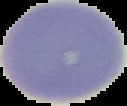

In [6]:
PIL.Image.open(uninfected[1])

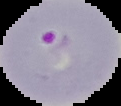

In [7]:
PIL.Image.open(parasitized[1])

In [8]:
from PIL import Image

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.size

def check_image_dimensions(directory):
    # List all files in the directory
    files = os.listdir(directory)

    # Filter out only image files
    image_files = [file for file in files if file.endswith(('jpg', 'jpeg', 'png', 'gif'))]

    # Iterate through each image file and print its dimensions
    for image_file in image_files:
        image_path = os.path.join(directory, image_file)
        dimensions = get_image_dimensions(image_path)
        print(f"Image: {image_file}, Dimensions: {dimensions}")

In [9]:
data_dir

PosixPath('/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images')

In [10]:
path

'/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images'

In [11]:
Uninfected_path = f'{path}/Uninfected/'
Infected_path = f'{path}/Parasitized/'

In [12]:
dim1 = []
dim2 = []
for image_filename in os.listdir(Uninfected_path):

    if not image_filename.endswith(('jpg', 'jpeg', 'png', 'gif')):
                         continue

    img = imread(Uninfected_path+image_filename)

    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

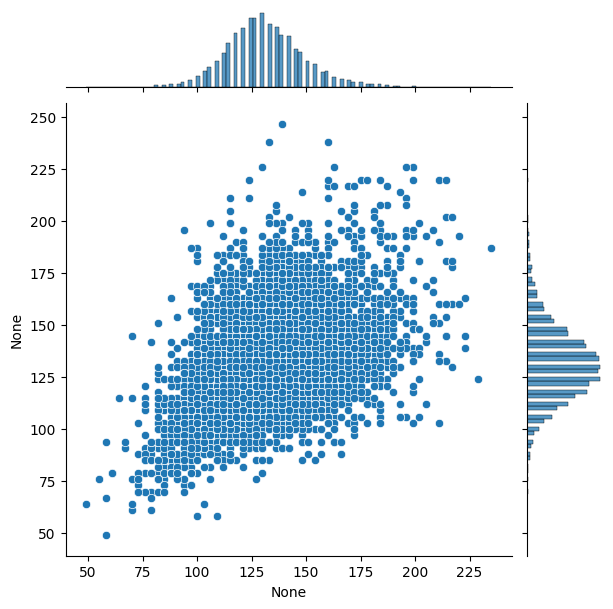

In [13]:
sns.jointplot(x=dim1, y=dim2, kind="scatter")
plt.show()

In [14]:
# mean of dimension of uninfected images
np.mean(dim1), np.mean(dim2)


(131.58001306335728, 131.3424776834313)

In [15]:
dim1 = []
dim2 = []
for image_filename in os.listdir(Infected_path):

    if not image_filename.endswith(('jpg', 'jpeg', 'png', 'gif')):
                         continue

    img = imread(Infected_path+image_filename)

    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

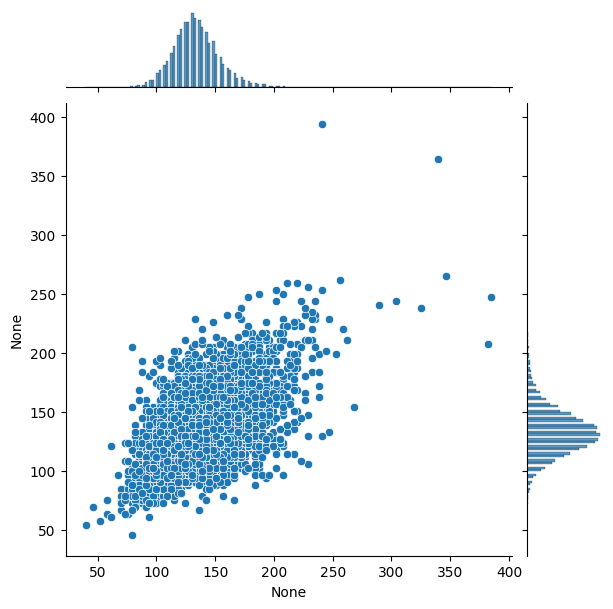

In [16]:
sns.jointplot(x=dim1, y=dim2, kind="scatter")
plt.show()

In [17]:
# mean of dimension of Infected images
np.mean(dim1), np.mean(dim2)

(134.3868930981929, 133.6318310472458)

In [18]:
# image size of both set of images is around 130 x 130
image_shape = (130,130,3)

In [39]:
from PIL import Image

image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # randomly shift the pic width by a max of 5%
                               height_shift_range=0.10, # randonly shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                               validation_split = 0.3,
                              )

### Testing ImageDataGenerator

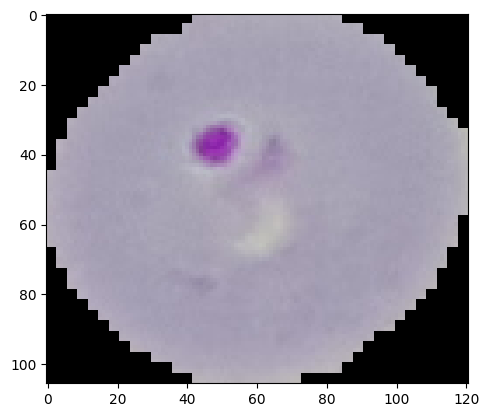

In [20]:
para_img = imread(parasitized[1])
plt.imshow(para_img)

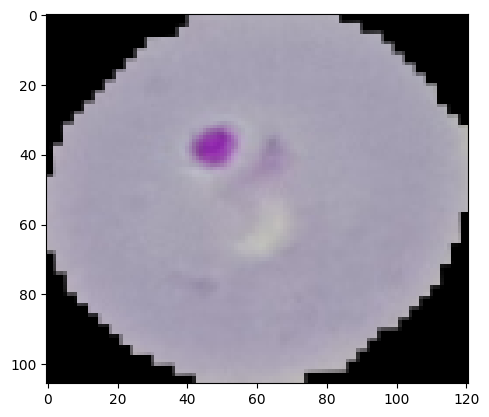

In [21]:
plt.imshow(image_gen.random_transform(para_img))

## Generating Manipulated Images from a Directory

In [40]:
batch_size = 32

In [41]:
training_data = image_gen.flow_from_directory(
    data_dir,
    subset = "training",
    class_mode="binary",
    target_size = image_shape[:2],
    batch_size = batch_size
)

validation_data = image_gen.flow_from_directory(
    data_dir,
    subset = "validation",
    class_mode="binary",
    target_size = image_shape[:2],
    batch_size = batch_size,
    shuffle=False
)

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


In [42]:
training_data.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [43]:
validation_data.class_indices

{'Parasitized': 0, 'Uninfected': 1}

## Creating the Model

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [45]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)       

## Early Stopping

In [47]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

## Training the Model

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
history = model.fit(training_data, epochs=25, validation_data=validation_data, callbacks=[early_stop])

Epoch 1/25
603/603 [==============================] - 157s 255ms/step - loss: 0.4612 - accuracy: 0.7956 - val_loss: 0.2073 - val_accuracy: 0.9163
Epoch 2/25
603/603 [==============================] - 151s 250ms/step - loss: 0.2030 - accuracy: 0.9339 - val_loss: 0.1715 - val_accuracy: 0.9285
Epoch 3/25
603/603 [==============================] - 188s 311ms/step - loss: 0.1787 - accuracy: 0.9440 - val_loss: 0.1715 - val_accuracy: 0.9446
Epoch 4/25
603/603 [==============================] - 147s 243ms/step - loss: 0.1635 - accuracy: 0.9487 - val_loss: 0.1505 - val_accuracy: 0.9453
Epoch 5/25
603/603 [==============================] - 147s 244ms/step - loss: 0.1623 - accuracy: 0.9497 - val_loss: 0.1513 - val_accuracy: 0.9470
Epoch 6/25
603/603 [==============================] - 150s 249ms/step - loss: 0.1602 - accuracy: 0.9495 - val_loss: 0.1630 - val_accuracy: 0.9506
Epoch 7/25
603/603 [==============================] - 152s 253ms/step - loss: 0.1583 - accuracy: 0.9498 - val_loss: 0.1586 -

## Evaluating the Model

In [50]:
losses = pd.DataFrame(model.history.history)

<Axes: >

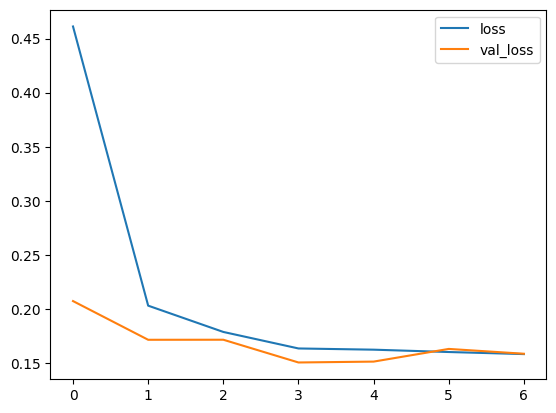

In [51]:
losses[['loss','val_loss']].plot()

In [ ]:
model.evaluate(validation_data)

In [ ]:
pred_probabilities = model.predict(validation_data).flatten()

In [54]:
predictions = (pred_probabilities > 0.5).astype(np.int32)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix(validation_data.classes,predictions)

In [56]:
print(classification_report(validation_data.classes,predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      4133
           1       0.95      0.94      0.95      4133

    accuracy                           0.95      8266
   macro avg       0.95      0.95      0.95      8266
weighted avg       0.95      0.95      0.95      8266

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      4133
           1       0.95      0.94      0.95      4133

    accuracy                           0.95      8266
   macro avg       0.95      0.95      0.95      8266
weighted avg       0.95      0.95      0.95      8266

